In [38]:
import math
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from matplotlib import pyplot as plt
from scipy.stats import kstest, shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
%matplotlib inline

In [39]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [40]:
def test_normality(data):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    sb.distplot(data)
    plt.show()
    ks_stat, ks_p = kstest(data, "norm")
    print("Kolmogorov-Smirnov Test Results: ")
    print("Test Statistics = ", ks_stat)
    print("P-value = ", ks_p)
    if ks_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")
    print("------------------------------------------------")
    sh_stat, sh_p = shapiro(data)
    print("Shapiro-Wilk Test Results: ")
    print("Test Statistics = ", sh_stat)
    print("P-value = ", sh_p)
    if sh_p > 0.05:
        print("Probably Gaussian.")
    else:
        print("Not Gausssian.")    

In [41]:
def plot(data_label_pairs, x_label, y_label, title):
    plt.figure(figsize=(6.40, 3.60), dpi=200)
    for data, label in data_label_pairs:
        plt.plot(data, label=label)
    plt.legend()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

In [42]:
def prepare_for_lstm(data, look_back):
    data_x, data_y = [], []
    for i in range(len(data) - look_back):
        data_window = data[i:i + look_back]
        data_x.append(data_window)
        data_y.append(data[i + look_back])
    return np.array(data_x), np.array(data_y)

In [43]:
def performance(actual, predicted):
    print("Performance:")
    mse = mean_squared_error(actual, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    mape = mean_absolute_percentage_error(actual, predicted) * 100
    print("mean squared error: ", mse)
    print("root mean square error: ", rmse)
    print("mean absolute error: ", mae)
    print("mean absolute percentage error: ", mape, "%")

In [44]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data.interpolate(inplace=True)
dates = list(ether_data.index)

In [45]:
ether_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
 4   Volume  2252 non-null   float64
 5   Change  2252 non-null   float64
dtypes: float64(6)
memory usage: 123.2 KB


In [46]:
ether_data.describe()

,Open,High,Low,Close,Volume,Change
count,2252.000000,2252.000000,2252.000000,2252.000000,2.252000e+03,2252.000000
mean,812.901239,841.363615,780.354378,813.961607,1.323084e+07,0.003973
std,1163.234596,1199.773415,1120.483259,1163.604697,1.037117e+08,0.056057
min,6.680000,7.320000,5.860000,6.700000,0.000000e+00,-0.445500
25%,135.372500,139.487500,130.700000,135.460000,5.336425e+05,-0.022300
50%,258.000000,268.905000,242.690000,258.900000,1.480000e+06,0.001100
75%,754.400000,798.180000,719.557500,759.147500,7.942500e+06,0.029425
max,4808.340000,4864.060000,4715.430000,4808.380000,1.790000e+09,0.295100


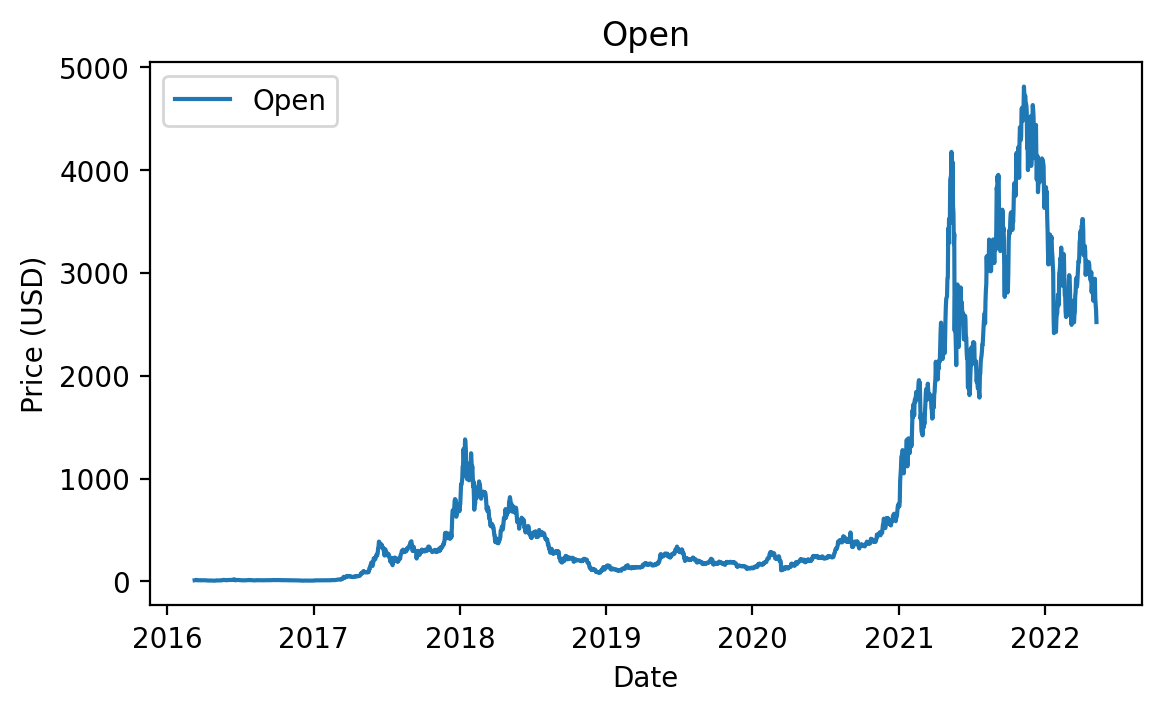

In [47]:
plot(data_label_pairs=[(ether_data["Open"], "Open")], x_label="Date", y_label="Price (USD)", title="Open")

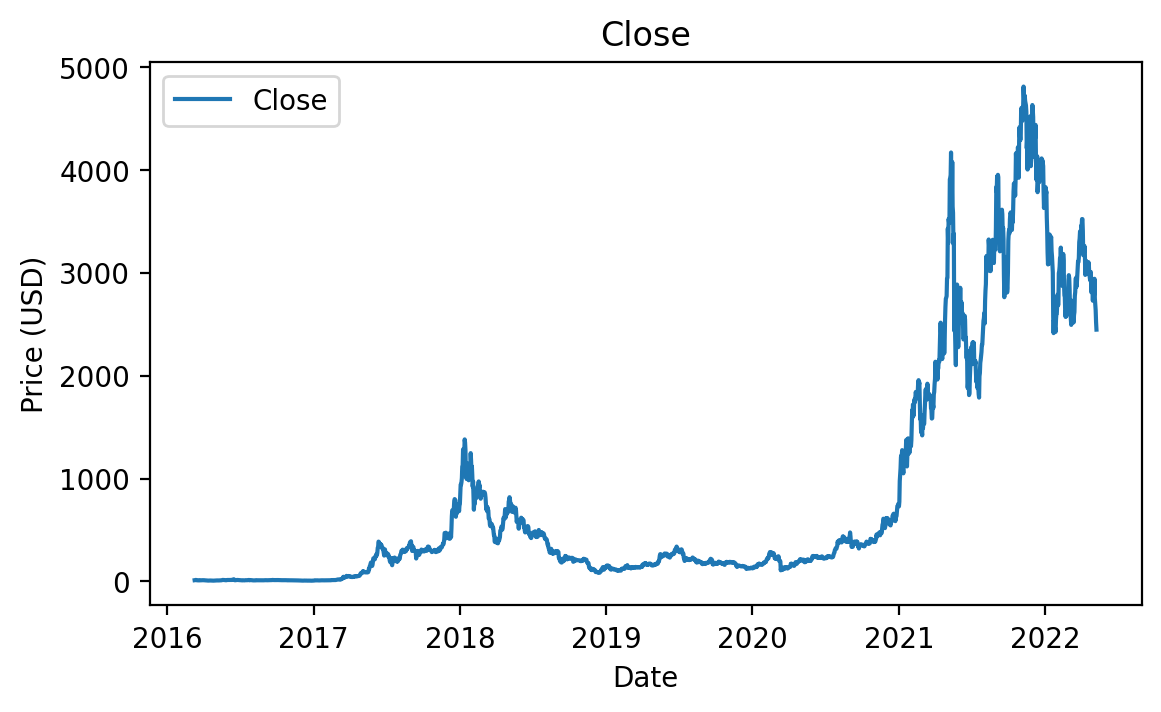

In [48]:
plot(data_label_pairs=[(ether_data["Close"], "Close")], x_label="Date", y_label="Price (USD)", title="Close")

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


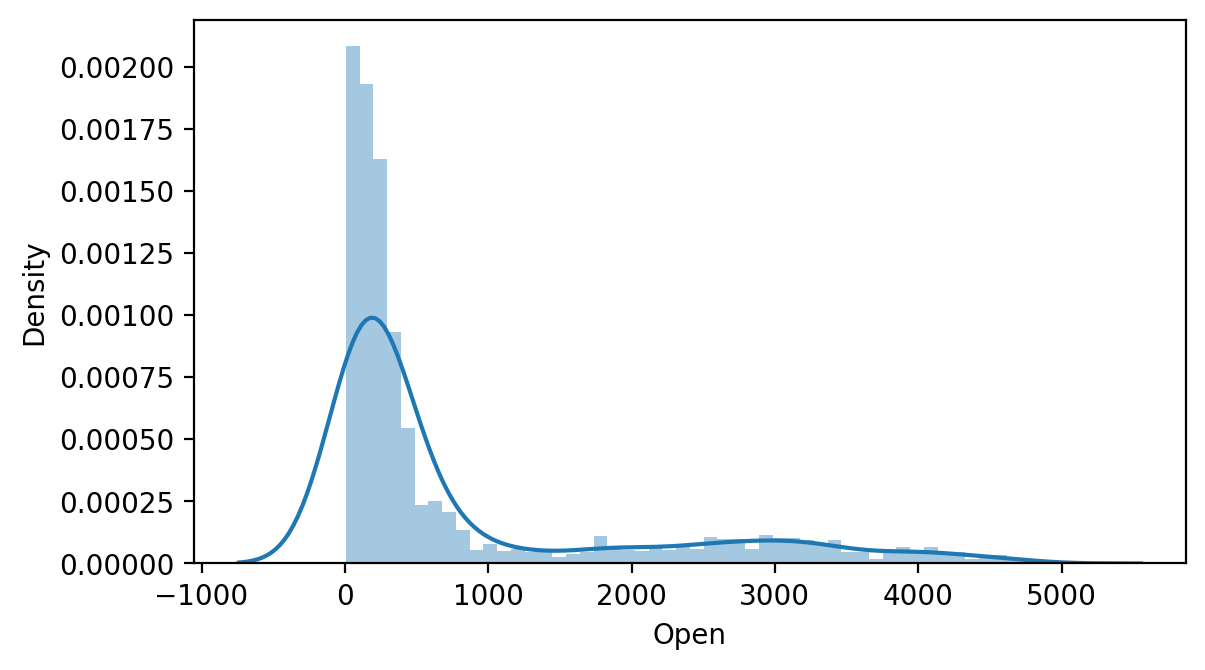

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999999880529
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6839131116867065
P-value =  0.0
Not Gausssian.


In [49]:
test_normality(ether_data["Open"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


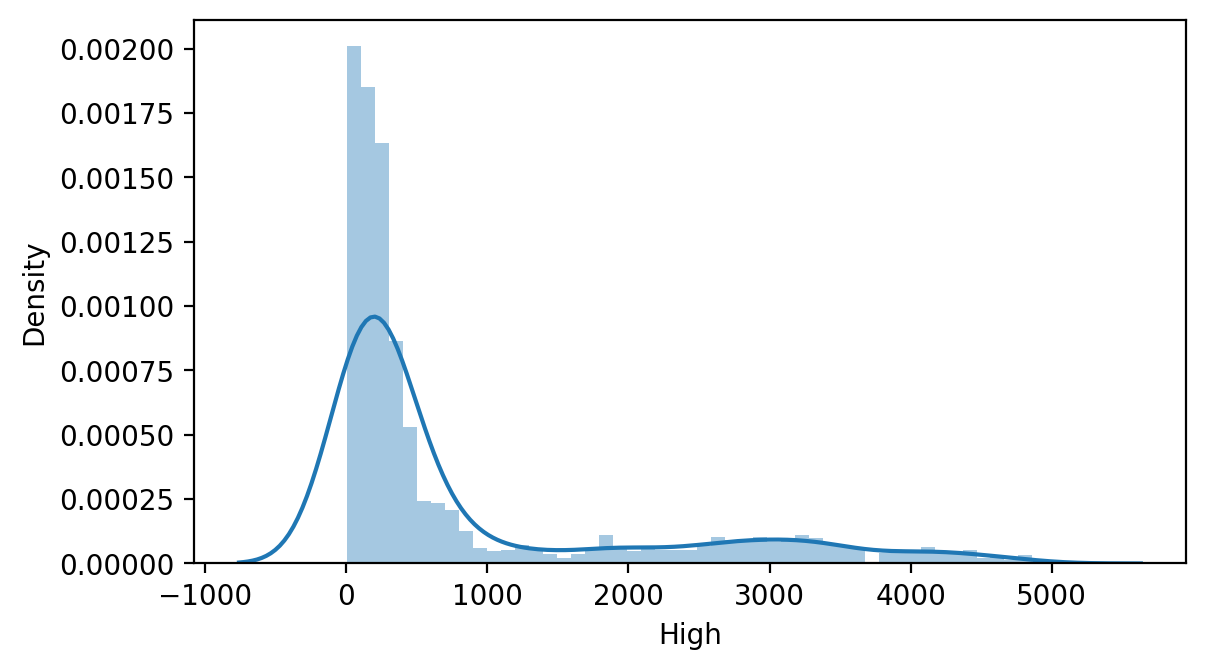

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999999876
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.685326099395752
P-value =  0.0
Not Gausssian.


In [50]:
test_normality(ether_data["High"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


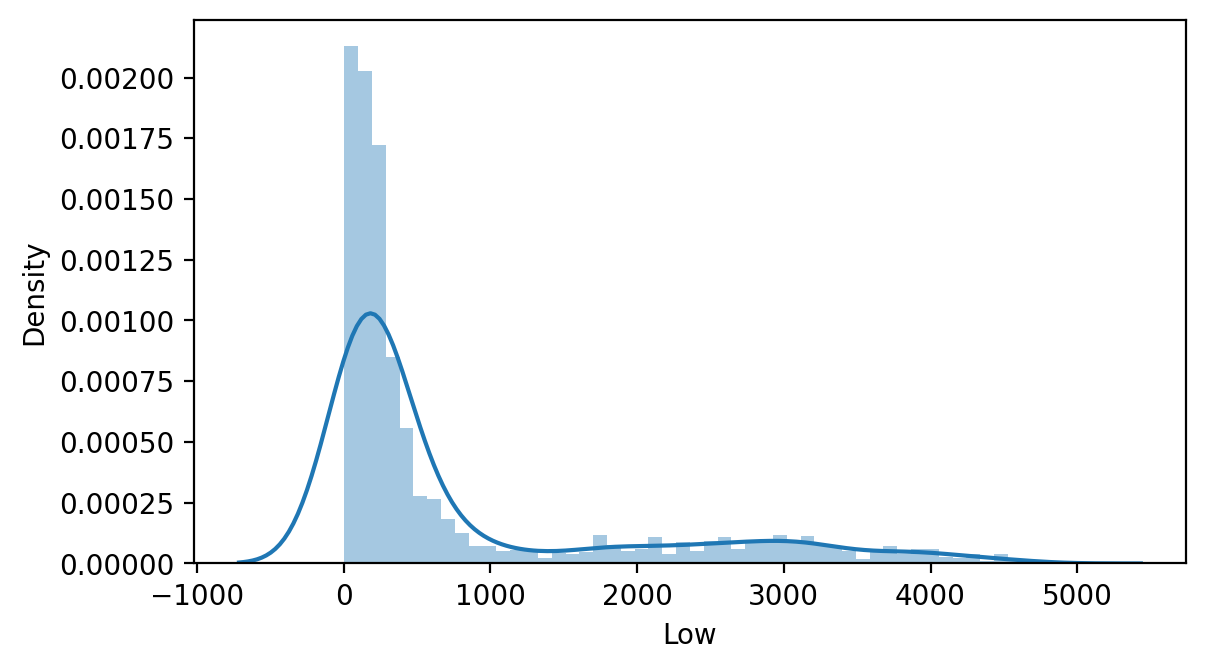

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.9999999976856642
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6821624040603638
P-value =  0.0
Not Gausssian.


In [51]:
test_normality(ether_data["Low"])

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


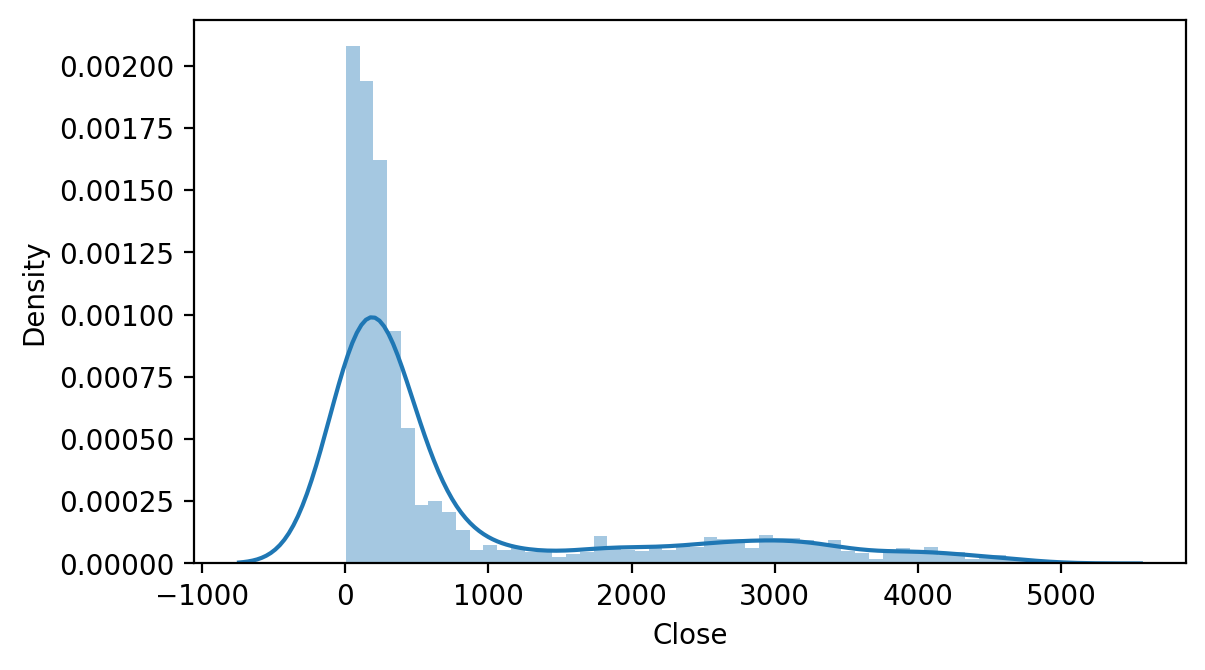

Kolmogorov-Smirnov Test Results: 
Test Statistics =  0.999999999989579
P-value =  0.0
Not Gausssian.
------------------------------------------------
Shapiro-Wilk Test Results: 
Test Statistics =  0.6844182014465332
P-value =  0.0
Not Gausssian.


In [52]:
test_normality(ether_data['Close'])

In [53]:
ether_data_uni = pd.DataFrame(ether_data, columns=["Close"])

In [54]:
ether_data_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [55]:
ether_data_uni.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2252 non-null   float64
dtypes: float64(1)
memory usage: 35.2 KB


In [56]:
ether_data_uni.describe()

,Close
count,2252.000000
mean,813.961607
std,1163.604697
min,6.700000
25%,135.460000
50%,258.900000
75%,759.147500
max,4808.380000


In [57]:
uni_training_size = int(len(ether_data_uni) * 0.80)
uni_test_size = len(ether_data_uni) - uni_training_size
train_ether_uni = ether_data_uni[:uni_training_size]
test_ether_uni = ether_data_uni[uni_training_size:]

In [58]:
train_ether_uni

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2021-02-08,1750.18
2021-02-09,1770.63
2021-02-10,1742.09


In [59]:
test_ether_uni

,Close
Date,
2021-02-13,1815.49
2021-02-14,1801.78
2021-02-15,1778.82
2021-02-16,1781.69
2021-02-17,1847.95
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [60]:
# standard_scaler = StandardScaler()
# scaled_train_uni = standard_scaler.fit_transform(train_ether_uni)
# scaled_test_uni = standard_scaler.fit_transform(test_ether_uni)
minmax_scaler = MinMaxScaler()
scaled_train_uni = minmax_scaler.fit_transform(train_ether_uni)
scaled_test_uni = minmax_scaler.fit_transform(test_ether_uni)

In [61]:
scaled_train_uni.shape

(1801, 1)

In [62]:
scaled_test_uni.shape

(451, 1)

In [63]:
uni_train_x, uni_train_y = prepare_for_lstm(scaled_train_uni, 3)
uni_test_x, uni_test_y = prepare_for_lstm(scaled_test_uni, 3)
uni_train_x = uni_train_x.reshape((-1, uni_train_x.shape[1], 1))
uni_test_x = uni_test_x.reshape((-1, uni_test_x.shape[1], 1))

In [64]:
# inversed_actual = standard_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual = minmax_scaler.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
actual_uni = pd.DataFrame(data=inversed_actual, index=dates[-1 * len(inversed_actual):], columns=["Close"])
actual_uni.index.name = "Date"

In [65]:
uni_train_x.shape, uni_train_y.shape

((1798, 3, 1), (1798, 1))

In [66]:
uni_test_x.shape, uni_test_y.shape

((448, 3, 1), (448, 1))

In [67]:
actual_uni

,Close
Date,
2021-02-16,1781.69
2021-02-17,1847.95
2021-02-18,1934.16
2021-02-19,1955.59
2021-02-20,1913.88
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [68]:
vanilla_model = tf.keras.models.Sequential()
vanilla_model.add(tf.keras.layers.LSTM(units=128, activation="relu", input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
vanilla_model.add(tf.keras.layers.Dense(units=1))
vanilla_model.summary()
vanilla_model.compile(optimizer="adam", loss="mse")
vanilla_results = vanilla_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 2s 8ms/step - loss: 0.0168 - val_loss: 0.0080
Epoch 2/50
57/57 [==============================] - 0s 4ms/step - loss: 4.7176e-04 - val_loss: 0.0029
Epoch 3/50
57/57 [==============================] - 0s 4ms/step - loss: 3.3875e-04 - val_loss: 0.0029
Epoch 4/50
57/57 [==============================] - 0s 5ms/step - loss: 3.2467e-04 - val_loss: 0.0033
Epoch 5/50
57/57 [========================

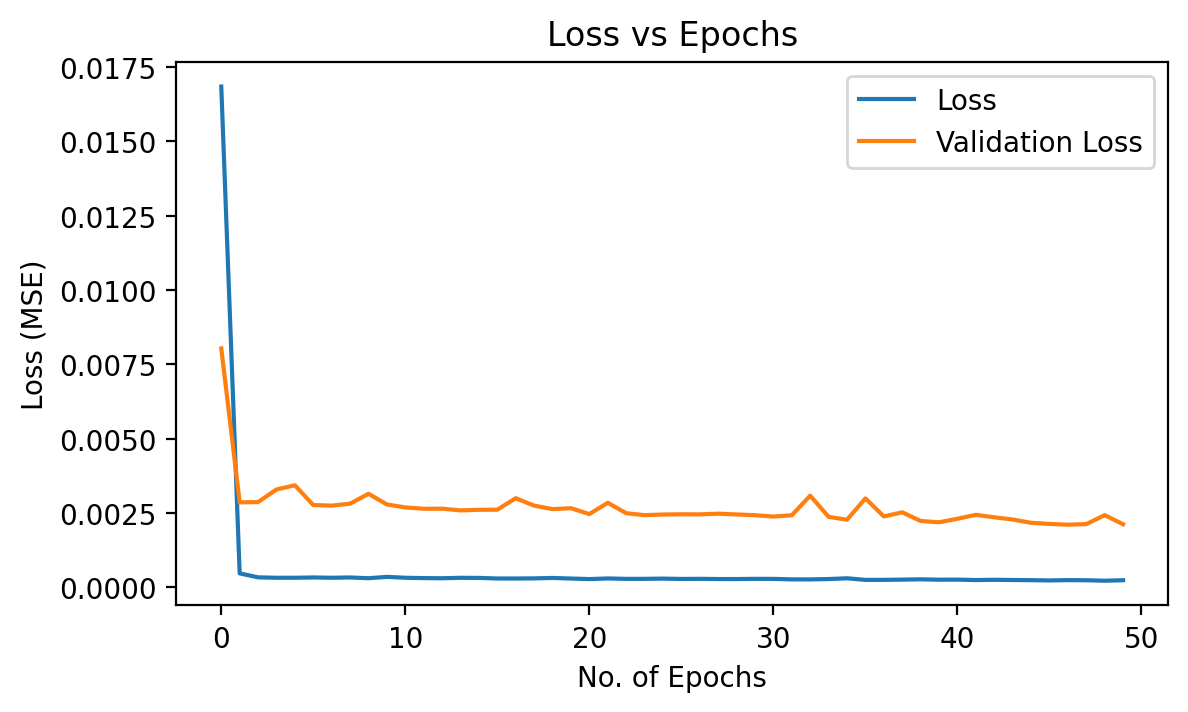

In [69]:
plot(data_label_pairs=[(vanilla_results.history["loss"], "Loss"), (vanilla_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [70]:
# predicted_vanilla =  pd.DataFrame(data=standard_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla =  pd.DataFrame(data=minmax_scaler.inverse_transform(vanilla_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [71]:
predicted_vanilla

,Predicted_Close
Date,
2021-02-16,1787.089233
2021-02-17,1778.274536
2021-02-18,1808.236206
2021-02-19,1874.682251
2021-02-20,1927.839844
...,...
2022-05-05,2878.563477
2022-05-06,2822.637695
2022-05-07,2722.720459


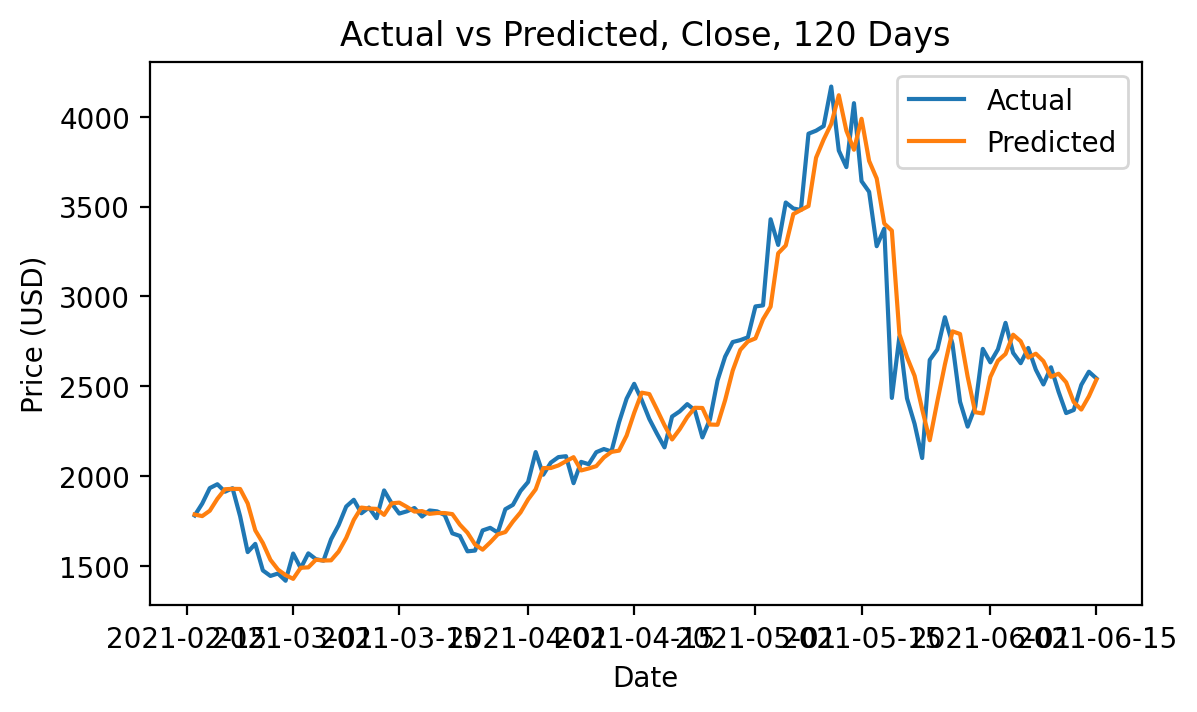

In [72]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_vanilla["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [73]:
performance(actual_uni["Close"][:120], predicted_vanilla["Predicted_Close"][:120])

Performance:
mean squared error:  31931.849716238776
root mean square error:  178.69485083862594
mean absolute error:  124.72734574381508
mean absolute percentage error:  5.177056185944821 %


In [74]:
stacked_model = tf.keras.models.Sequential()
stacked_model.add(tf.keras.layers.LSTM(units=128, activation="relu", return_sequences=True,  input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
stacked_model.add(tf.keras.layers.LSTM(units=64, activation="relu"))
stacked_model.add(tf.keras.layers.Dense(units=1))
stacked_model.summary()
stacked_model.compile(optimizer="adam", loss="mse")
stacked_results = stacked_model.fit(uni_train_x, uni_train_y, epochs=50, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 128)            66560     
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
57/57 [==============================] - 3s 15ms/step - loss: 0.0190 - val_loss: 0.0036
Epoch 2/50
57/57 [==============================] - 0s 5ms/step - loss: 5.9442e-04 - val_loss: 0.0033
Epoch 3/50
57/57 [==============================] - 0s 5ms/step - loss: 3.8920e-04 - val_loss: 0.0032
Epoch 4/5

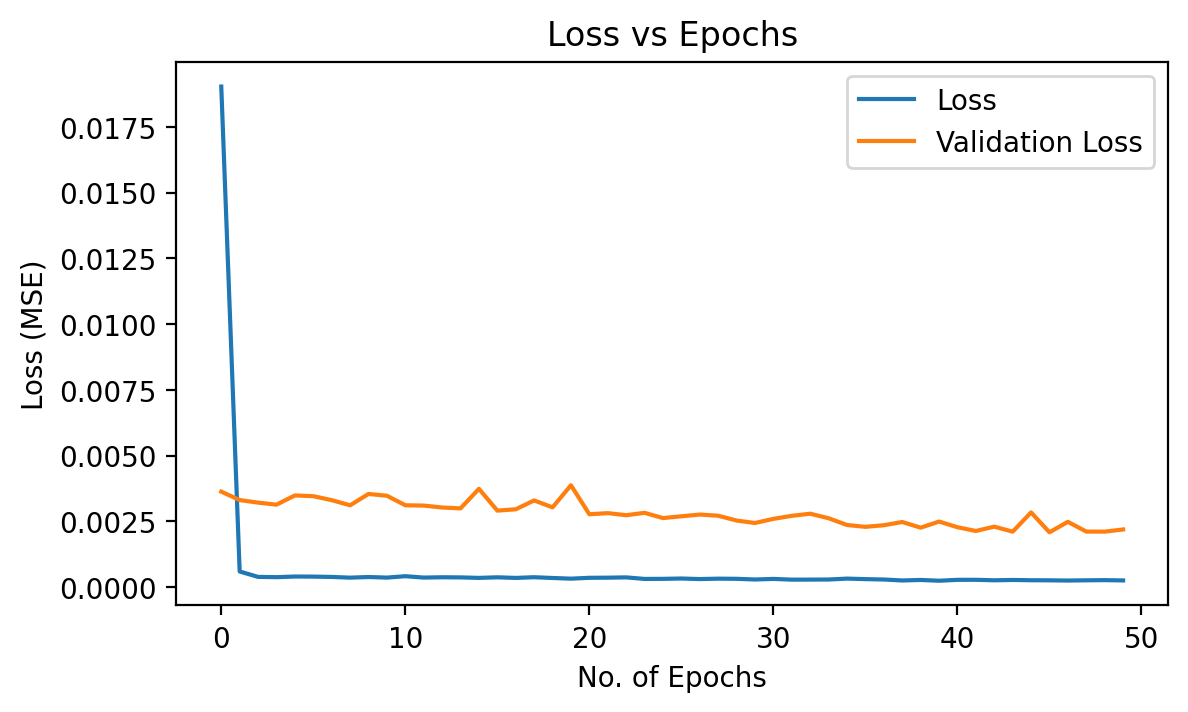

In [75]:
plot(data_label_pairs=[(stacked_results.history["loss"], "Loss"), (stacked_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [76]:
# predicted_stacked =  pd.DataFrame(data=standard_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked =  pd.DataFrame(data=minmax_scaler.inverse_transform(stacked_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_stacked.index.name = "Date"

In [77]:
predicted_stacked

,Predicted_Close
Date,
2021-02-16,1748.806396
2021-02-17,1737.454346
2021-02-18,1760.297729
2021-02-19,1822.535645
2021-02-20,1877.733765
...,...
2022-05-05,2842.826416
2022-05-06,2785.346191
2022-05-07,2671.775635


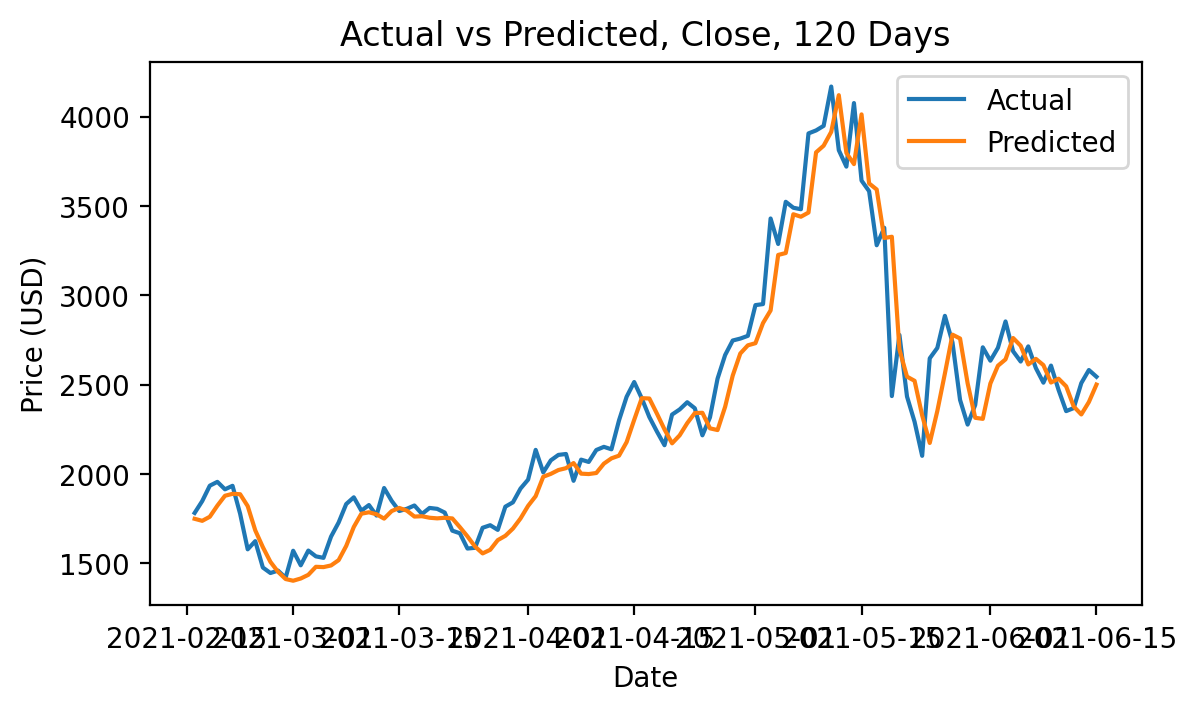

In [78]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [79]:
performance(actual_uni, predicted_stacked)

Performance:
mean squared error:  25181.660945449024
root mean square error:  158.6873055586017
mean absolute error:  120.65062695094517
mean absolute percentage error:  4.250522081765297 %


In [80]:
bidirectional_model = tf.keras.models.Sequential()
bidirectional_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="sigmoid"), input_shape=(uni_train_x.shape[1], uni_train_x.shape[2])))
bidirectional_model.add(tf.keras.layers.Dense(units=1))
bidirectional_model.summary()
bidirectional_model.compile(optimizer="adam", loss="mse")
bidirectional_results = bidirectional_model.fit(uni_train_x, uni_train_y, batch_size=256, epochs=30, verbose=1, validation_data=(uni_test_x, uni_test_y))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              133120    
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
8/8 [==============================] - 2s 66ms/step - loss: 0.0537 - val_loss: 0.2406
Epoch 2/30
8/8 [==============================] - 0s 14ms/step - loss: 0.0322 - val_loss: 0.0888
Epoch 3/30
8/8 [==============================] - 0s 23ms/step - loss: 0.0241 - val_loss: 0.1529
Epoch 4/30
8/8 [==============================] - 0s 13ms/step - loss: 0.0210 - val_los

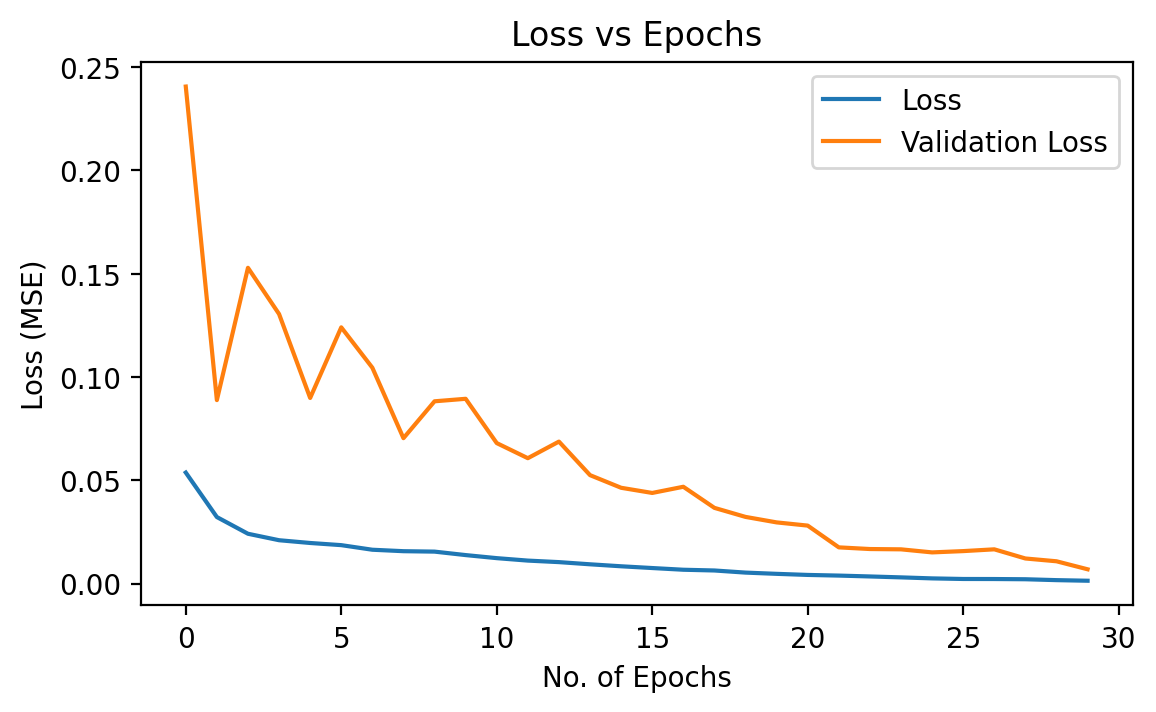

In [81]:
plot(data_label_pairs=[(bidirectional_results.history["loss"], "Loss"), (bidirectional_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [82]:
# predicted_bidirectional =  pd.DataFrame(data=standard_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional =  pd.DataFrame(data=minmax_scaler.inverse_transform(bidirectional_model.predict(uni_test_x)), index=dates[-1 * len(inversed_actual):], columns=["Predicted_Close"])
predicted_bidirectional.index.name = "Date"

In [83]:
predicted_bidirectional

,Predicted_Close
Date,
2021-02-16,1830.480713
2021-02-17,1823.816284
2021-02-18,1838.995972
2021-02-19,1877.982544
2021-02-20,1919.288208
...,...
2022-05-05,2717.258057
2022-05-06,2644.479004
2022-05-07,2657.257812


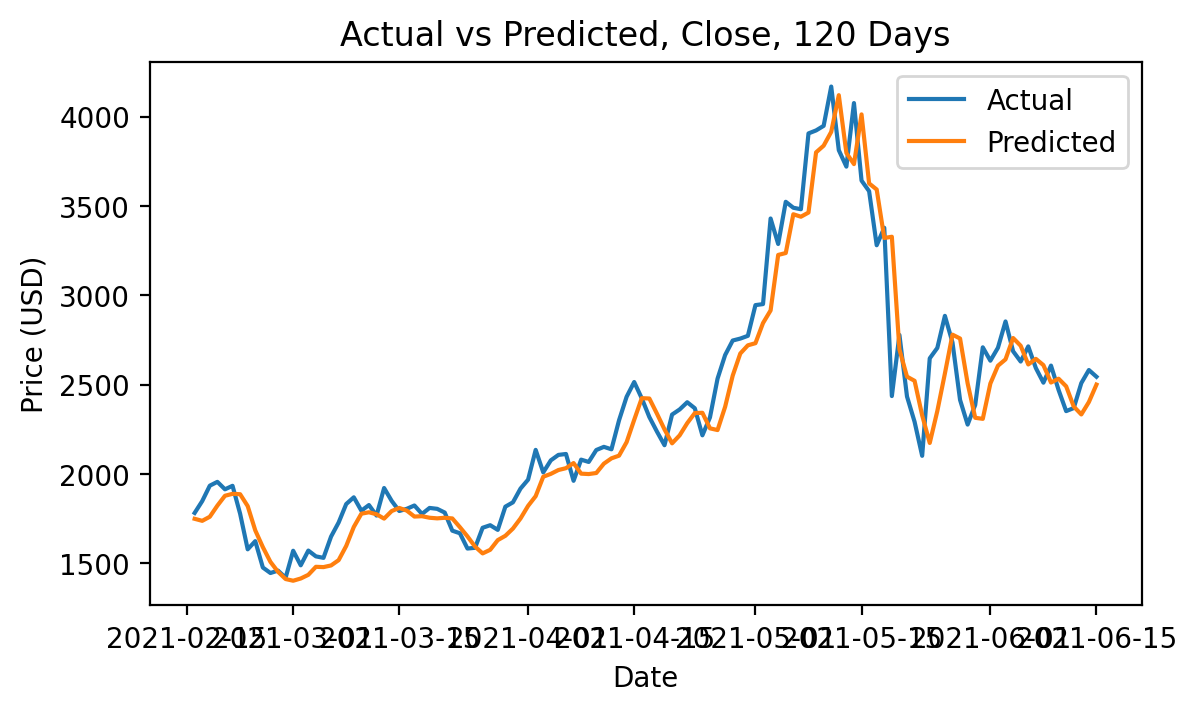

In [84]:
plot(data_label_pairs=[(actual_uni["Close"][:120], "Actual"), (predicted_stacked["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [85]:
performance(actual_uni, predicted_bidirectional)

Performance:
mean squared error:  79405.07330975533
root mean square error:  281.7890581796166
mean absolute error:  223.99188053676062
mean absolute percentage error:  7.03396643826899 %


In [86]:
ether_data.corr()

,Open,High,Low,Close,Volume,Change
Open,1.000000,0.999374,0.998569,0.998238,0.104588,-0.032946
High,0.999374,1.000000,0.998477,0.999155,0.104855,-0.017002
Low,0.998569,0.998477,1.000000,0.999118,0.106389,-0.012295
Close,0.998238,0.999155,0.999118,1.000000,0.105243,0.000184
Volume,0.104588,0.104855,0.106389,0.105243,1.000000,0.000230
Change,-0.032946,-0.017002,-0.012295,0.000184,0.000230,1.000000


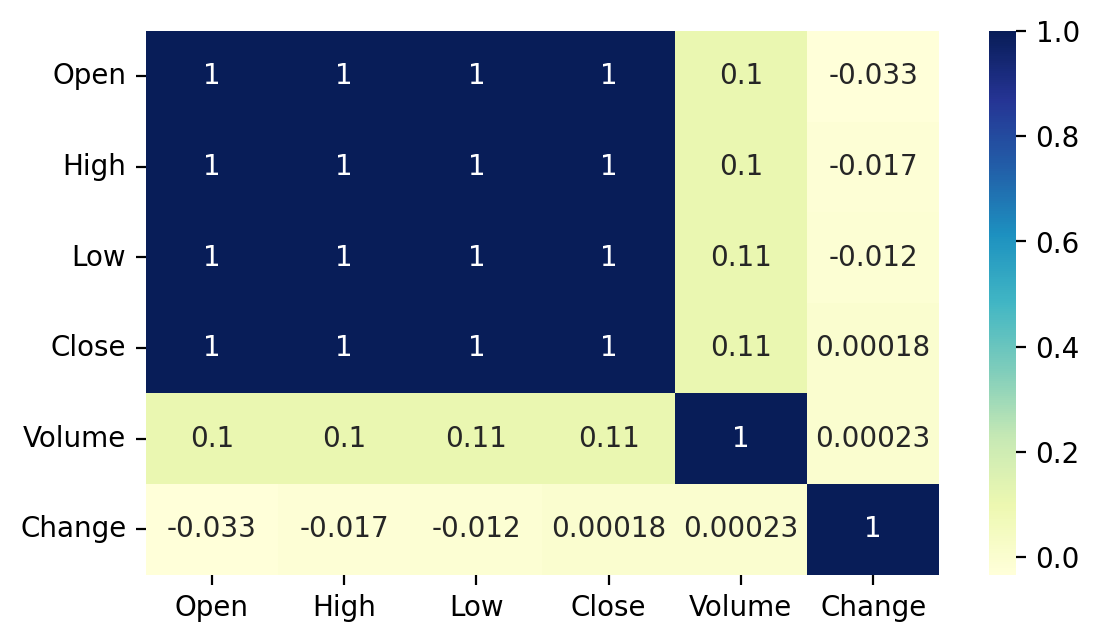

In [87]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
sb.heatmap(ether_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [88]:
ether_data_multi = pd.DataFrame(ether_data, columns=["Open", "High", "Low", "Close"])

In [89]:
ether_data_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [90]:
ether_data_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2252 non-null   float64
 1   High    2252 non-null   float64
 2   Low     2252 non-null   float64
 3   Close   2252 non-null   float64
dtypes: float64(4)
memory usage: 88.0 KB


In [91]:
ether_data_multi.describe()

,Open,High,Low,Close
count,2252.000000,2252.000000,2252.000000,2252.000000
mean,812.901239,841.363615,780.354378,813.961607
std,1163.234596,1199.773415,1120.483259,1163.604697
min,6.680000,7.320000,5.860000,6.700000
25%,135.372500,139.487500,130.700000,135.460000
50%,258.000000,268.905000,242.690000,258.900000
75%,754.400000,798.180000,719.557500,759.147500
max,4808.340000,4864.060000,4715.430000,4808.380000


In [92]:
multi_training_size = int(len(ether_data_multi) * 0.90)
multi_test_size = len(ether_data_multi) - multi_training_size
train_ether_multi = ether_data_multi[:multi_training_size]
test_ether_multi = ether_data_multi[multi_training_size:]

In [93]:
train_ether_multi

,Open,High,Low,Close
Date,,,,
2016-03-10,11.20,11.85,11.07,11.75
2016-03-11,11.75,11.95,11.75,11.95
2016-03-12,11.95,13.45,11.95,12.92
2016-03-13,12.92,15.07,12.92,15.07
2016-03-14,15.07,15.07,11.40,12.50
...,...,...,...,...
2021-09-21,2976.70,3101.88,2659.71,2761.52
2021-09-22,2764.71,3087.97,2740.58,3077.78
2021-09-23,3077.80,3173.00,3035.96,3152.92


In [94]:
test_ether_multi

,Open,High,Low,Close
Date,,,,
2021-09-26,2922.47,3113.65,2740.12,3063.51
2021-09-27,3061.86,3163.86,2926.24,2926.24
2021-09-28,2926.04,2969.18,2791.42,2807.28
2021-09-29,2807.15,2948.50,2784.66,2851.50
2021-09-30,2851.06,3047.08,2837.68,3000.59
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [95]:
# standard_scaler_multi = StandardScaler()
# scaled_train_multi = standard_scaler_multi.fit_transform(train_ether_multi)
# scaled_test_multi = standard_scaler_multi.fit_transform(test_ether_multi)
minmax_scaler_multi = MinMaxScaler()
scaled_train_multi = minmax_scaler_multi.fit_transform(train_ether_multi)
scaled_test_multi = minmax_scaler_multi.fit_transform(test_ether_multi)

In [96]:
scaled_train_multi.shape

(2026, 4)

In [97]:
scaled_test_multi.shape

(226, 4)

In [98]:
multi_train_x, multi_train_y = prepare_for_lstm(scaled_train_multi, 5)
multi_test_x, multi_test_y = prepare_for_lstm(scaled_test_multi, 5)

In [99]:
multi_train_x.shape, multi_train_y.shape

((2021, 5, 4), (2021, 4))

In [100]:
multi_test_x.shape, multi_test_y.shape

((221, 5, 4), (221, 4))

In [101]:
# inversed_actual_multi = standard_scaler_multi.inverse_transform(uni_test_y.reshape(-1, uni_test_y.shape[1]))
inversed_actual_multi = minmax_scaler_multi.inverse_transform(multi_test_y)
actual_multi = pd.DataFrame(data=inversed_actual_multi, index=dates[-1 * len(inversed_actual_multi):], columns=["Open", "High", "Low", "Close"])
actual_multi.index.name = "Date"

In [102]:
actual_multi

,Open,High,Low,Close
Date,,,,
2021-10-01,2999.86,3329.32,2972.75,3309.13
2021-10-02,3309.14,3467.95,3265.97,3388.97
2021-10-03,3388.83,3485.48,3346.63,3417.34
2021-10-04,3417.26,3436.34,3273.22,3382.90
2021-10-05,3383.32,3540.83,3365.28,3517.26
...,...,...,...,...
2022-05-05,2940.70,2952.84,2730.95,2747.46
2022-05-06,2747.60,2757.14,2635.85,2692.88
2022-05-07,2692.92,2703.11,2589.29,2636.03


In [109]:
multi_model = tf.keras.models.Sequential()
multi_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=128, activation="sigmoid", return_sequences=True), input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.5))
multi_model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.4))
multi_model.add(tf.keras.layers.LSTM(units=32, return_sequences=True, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.3))
multi_model.add(tf.keras.layers.LSTM(units=16, input_shape=(multi_train_x.shape[1], multi_train_x.shape[2])))
multi_model.add(tf.keras.layers.Dropout(0.2))
multi_model.add(tf.keras.layers.Dense(units=multi_train_x.shape[2]))
multi_model.summary()
multi_model.compile(optimizer="adam", loss="mse")
multi_results = multi_model.fit(multi_train_x, multi_train_y, batch_size=256, epochs=12, verbose=1, validation_data=(multi_test_x, multi_test_y))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 5, 256)           136192    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 256)            0         
                                                                 
 lstm_12 (LSTM)              (None, 5, 64)             82176     
                                                                 
 dropout_5 (Dropout)         (None, 5, 64)             0         
                                                                 
 lstm_13 (LSTM)              (None, 5, 32)             12416     
                                                                 
 dropout_6 (Dropout)         (None, 5, 32)             0         
                                                      

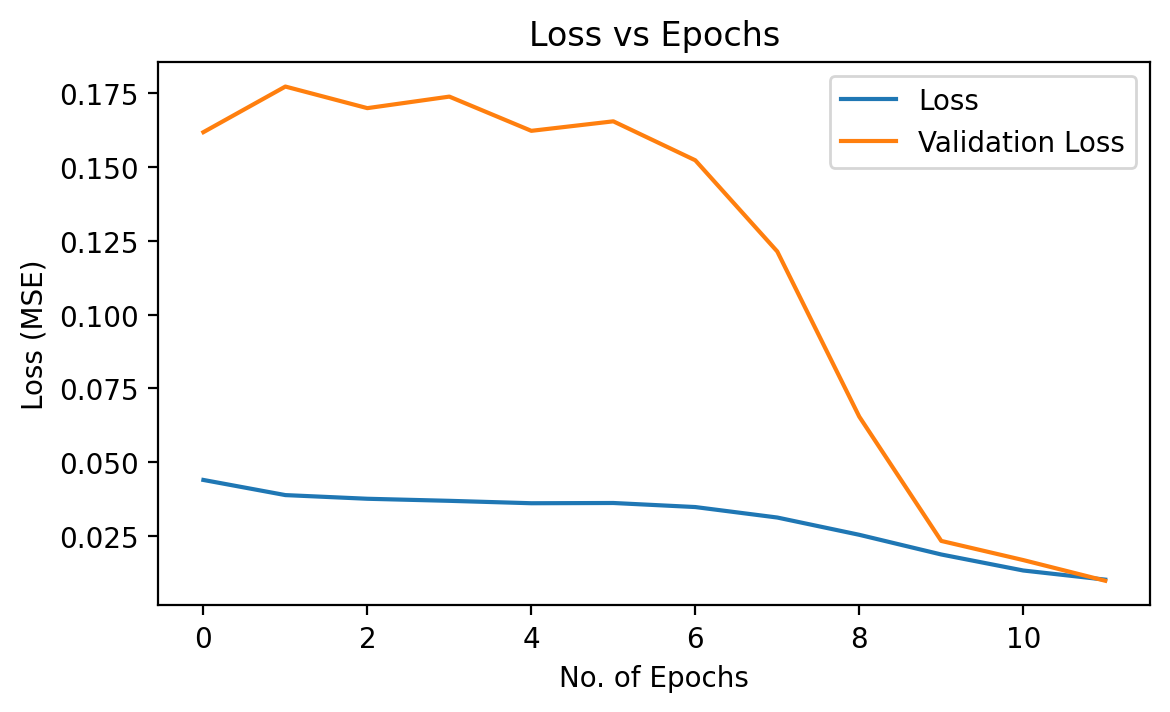

In [110]:
plot(data_label_pairs=[(multi_results.history["loss"], "Loss"), (multi_results.history["val_loss"], "Validation Loss")], x_label="No. of Epochs", y_label="Loss (MSE)", title="Loss vs Epochs")

In [111]:
# predicted_multi =  pd.DataFrame(data=standard_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_multi =  pd.DataFrame(data=minmax_scaler_multi.inverse_transform(multi_model.predict(multi_test_x)), index=dates[-1 * len(inversed_actual_multi):], columns=["Predicted_Open", "Predicted_High", "Predicted_Low", "Predicted_Close"])
predicted_vanilla.index.name = "Date"

In [112]:
predicted_multi

,Predicted_Open,Predicted_High,Predicted_Low,Predicted_Close
2021-10-01,2785.574463,2867.595215,2561.969482,2810.480713
2021-10-02,2787.215088,2869.782471,2564.110352,2808.981445
2021-10-03,2811.586670,2896.788086,2592.540771,2826.930420
2021-10-04,2919.226562,3010.574463,2711.093018,2942.797607
2021-10-05,3078.413818,3181.650146,2887.590820,3123.759766
...,...,...,...,...
2022-05-05,2676.198975,2757.392822,2447.866455,2682.411621
2022-05-06,2689.060791,2770.327148,2461.274658,2697.048096
2022-05-07,2693.956055,2774.763184,2466.011963,2704.728760
2022-05-08,2678.524658,2758.711426,2449.572510,2689.635498


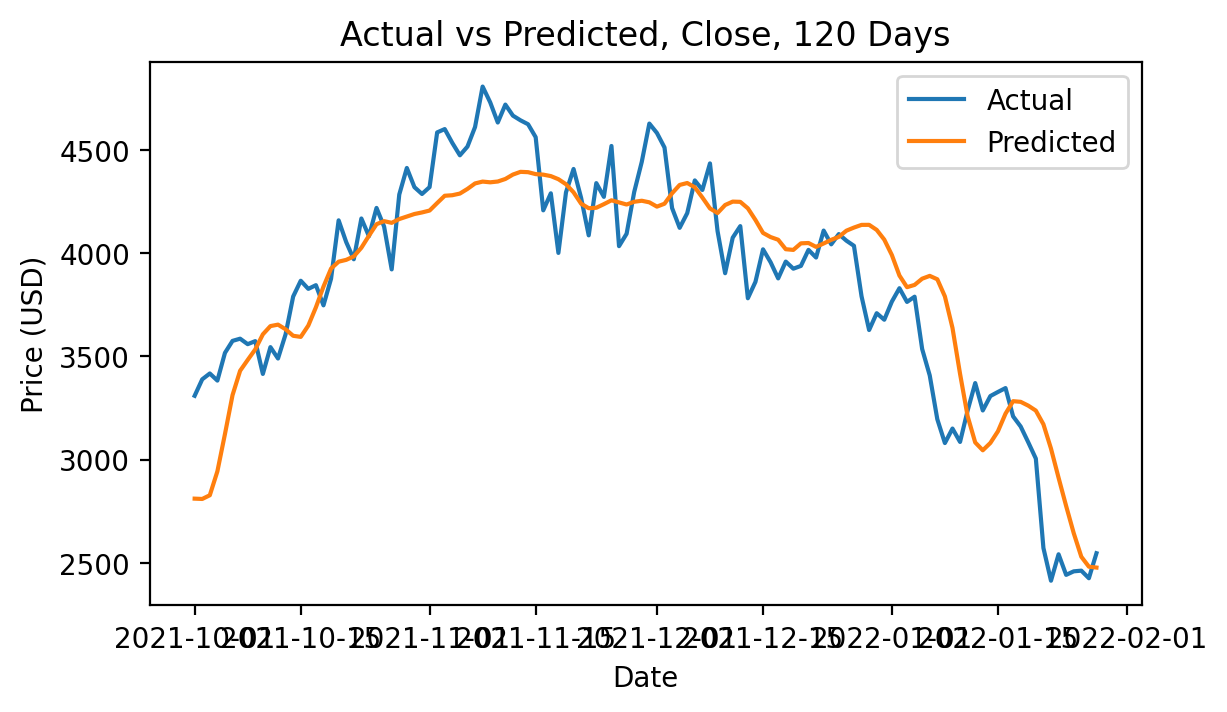

In [113]:
plot(data_label_pairs=[(actual_multi["Close"][:120], "Actual"), (predicted_multi["Predicted_Close"][:120], "Predicted")], x_label="Date", y_label="Price (USD)", title="Actual vs Predicted, Close, 120 Days")

In [114]:
performance(actual_multi["Close"], predicted_multi["Predicted_Close"])

Performance:
mean squared error:  57372.60038504783
root mean square error:  239.52578229712105
mean absolute error:  190.3446228966346
mean absolute percentage error:  5.717686561965567 %
